<h1 style="background-color:#a83299;font-family:newtimeroman;font-size:300%;text-align:center;border-radius: 20px 20px;font-family:cursive">Clustering text documents using k-means</h1>

In this notebook, it explained that the case of text document clustering , showing how the `scikit-learn` package can be used to perform clustering. Doing this, you will review:
1. How a document is converted into a vector of features. In particular, it considered that tf-idf vectorization.
2. How k-means clustering can be applied to perform unsupervised clustering of the documents.
3. How this is done in practice using the `scikit-learn` package.

Import libraries

In [ ]:
from sklearn.datasets import fetch_20newsgroups
from nltk.tokenize import word_tokenize #Used to extract words from documents
from nltk.stem import WordNetLemmatizer #Used to lemmatize words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn import metrics

from sklearn.cluster import KMeans

import sys
from time import time

import pandas as pd
import numpy as np

This code block defines a list of three categories selected from the 20 newsgroups dataset, which are 'talk.religion.misc', 'comp.graphics', and 'sci.space'. It then prints a message indicating that the code is loading the 20 newsgroups dataset for these three categories.






In [ ]:
# Selected 3 categories from the 20 newsgroups dataset

categories = [
    'talk.religion.misc',
    'comp.graphics',
    'sci.space',
]

print("Loading 20 newsgroups dataset for categories:")
print(categories)

Loading 20 newsgroups dataset for categories:
['talk.religion.misc', 'comp.graphics', 'sci.space']


This code block fetches the 20 newsgroups dataset, which has been filtered to include only the categories specified in the 'categories' list. The 'subset' parameter is set to 'all', indicating that all the data from the selected categories will be included. The 'shuffle' parameter is set to False, meaning that the data will not be randomly shuffled. Finally, the 'remove' parameter is used to remove certain parts of each document, such as headers, footers, and quotes. The fetched data is stored in a Pandas DataFrame named 'df'.






In [ ]:
df = fetch_20newsgroups(subset='all', categories=categories, 
                             shuffle=False, remove=('headers', 'footers', 'quotes'))

This code block assigns the target values (i.e., labels) of the fetched 20 newsgroups dataset stored in the Pandas DataFrame 'df' to a variable named 'labels'. It then computes the number of unique labels using NumPy's 'unique' function and stores it in a variable named 'true_k'. Finally, it prints the value of 'true_k', which should be equal to the number of categories specified in the previous code block (i.e., 3 in this case).






In [ ]:
labels = df.target
true_k = len(np.unique(labels)) ## This should be 3 in this example
print(true_k)

3


### Perform Lemmatization

In [ ]:
import nltk
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

This code block performs lemmatization on the documents in the fetched 20 newsgroups dataset stored in the Pandas DataFrame 'df'. It first initializes a WordNetLemmatizer object. Then, for each document in the dataset, it tokenizes the text into individual words using the 'word_tokenize' function from the NLTK library. It then applies lemmatization to each word using the 'lemmatize' method of the WordNetLemmatizer object, and appends the resulting lemmatized word to a string. Finally, it assigns the lemmatized string to the corresponding document in the DataFrame. The end result is a DataFrame with lemmatized documents.






In [ ]:
lemmatizer = WordNetLemmatizer()
for i in range(len(df.data)):
    word_list = word_tokenize(df.data[i])
    lemmatized_doc = ""
    for word in word_list:
        lemmatized_doc = lemmatized_doc + " " + lemmatizer.lemmatize(word)
    df.data[i] = lemmatized_doc  

In [ ]:
print(df.data[1])

 In regard to fractal commpression , I have seen 2 fractal compressed `` movie '' . They were both fairly impressive . The first one wa a 64 gray scale `` movie '' of Casablanca , it wa 1.3MB and had 11 minute of 13 fps video . It wa a little grainy but not bad at all . The second one I saw wa only 3 minute but it had 8 bit color with 10fps and measured in at 1.2MB . I consider the fractal movie a practical thing to explore . But unlike many other format out there , you do end up losing resolution . I do n't know what kind of software/hardware wa used for creating the `` movie '' I saw but the guy that showed them to me said it took 5-15 minute per frame to generate . But a I said above playback wa 10 or more frame per second . And how else could you put 11 minute on one floppy disk ?


We next convert our corpus into tf-idf vectors. We remove common stop words, terms with very low document frequency (many of them are numbers or misspells), accents. 

This code block creates a TfidfVectorizer object from the scikit-learn library, which will be used to transform the lemmatized documents in the 20 newsgroups dataset into a numerical representation. The 'strip_accents' parameter is set to 'unicode' to remove accents from words, and the 'stop_words' parameter is set to 'english' to remove common English stop words. The 'min_df' parameter is set to 2 to remove words that occur in fewer than two documents. The resulting TfidfVectorizer object is then applied to the lemmatized documents in the DataFrame using the 'fit_transform' method, which produces a sparse matrix 'X' with numerical representations of the documents.






In [ ]:
vectorizer = TfidfVectorizer(strip_accents='unicode', stop_words='english', min_df=2) ## Corpus is in English
X = vectorizer.fit_transform(df.data)

In [ ]:
print(X.shape)

(2588, 14439)


### Clustering using standard k-means

We first cluster documents using the standard k-means algorithm (actually, a refined variant called k-means++), without any further date preprocessing. The key parameter of choice when performing k-means is $k$. Alas, there really is no principled way to choose an initial value for $k$. Essentially we have two options:

1. We choose a value that reflects our knowledge about the data, as in this case
2. We may try several value, possibly in increasing order. We proceed this way as long as the quality of the resulting clustering (as measured by one or more quality indices) increases and stop when it starts decreasing. 

In this specific case, we set $k = 3$ of course

This code block applies the K-means clustering algorithm to the sparse matrix 'X', which contains the numerical representations of the lemmatized documents in the 20 newsgroups dataset. The 'n_clusters' parameter is set to the value of 'true_k', which is the number of categories in the dataset. The 'init' parameter is set to 'k-means++', which is a method for initializing the centroids. The 'max_iter' parameter is set to 100, which is the maximum number of iterations allowed for convergence. The K-means algorithm is then applied to the sparse matrix 'X' using the 'fit' method of the KMeans object, and the time taken for the algorithm to complete is printed. The end result is a fitted K-means clustering model that can be used to predict the cluster labels of new documents.






In [ ]:
km = KMeans(n_clusters=true_k, init='k-means++', max_iter=100)
t0 = time()
km.fit(X)
print("done in %0.3fs" % (time() - t0))

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


done in 0.507s


### Standard measures of cluster quality

This code block computes several metrics to evaluate the performance of the K-means clustering algorithm on the 20 newsgroups dataset. The 'homogeneity_score', 'completeness_score', and 'v_measure_score' functions from the scikit-learn library are used to compute the homogeneity, completeness, and V-measure of the clustering results, respectively. The 'adjusted_rand_score' function is used to compute the adjusted Rand index, which measures the similarity between the true and predicted cluster labels. Finally, the 'silhouette_score' function is used to compute the silhouette coefficient, which measures the quality of the clustering by evaluating the distance between data points in different clusters relative to the distance between data points in the same cluster. The results of these metrics are printed to the console.






In [ ]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels, km.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(labels, km.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(labels, km.labels_))
print("Adjusted Rand-Index: %.3f"
      % metrics.adjusted_rand_score(labels, km.labels_))
print("Silhouette Coefficient: %0.3f"
      % metrics.silhouette_score(X, km.labels_, sample_size=1000))

Homogeneity: 0.330
Completeness: 0.432
V-measure: 0.374
Adjusted Rand-Index: 0.276
Silhouette Coefficient: 0.009


### Identify the 10 most relevant terms in each cluster

This code block displays the top 10 most important words for each of the clusters found by the K-means algorithm. The 'cluster_centers_' attribute of the KMeans object is used to obtain the centroids of each cluster, which represent the average feature values of the documents in the cluster. These centroids are sorted in descending order using the 'argsort' method of the NumPy array, and the resulting indices are stored in the 'centroids' variable. The 'get_feature_names_out' method of the TfidfVectorizer object is used to obtain the names of the features (i.e., words) in the vocabulary, which are stored in the 'terms' variable. The 'terms' and 'centroids' variables are then used to print the top 10 most important words for each cluster to the console.






In [ ]:
centroids = km.cluster_centers_.argsort()[:, ::-1] ## Indices of largest centroids' entries in descending order
terms = vectorizer.get_feature_names_out()
for i in range(true_k):
    print("Cluster %d:" % i, end='')
    for ind in centroids[i, :10]:
        print(' %s' % terms[ind], end='')
    print()

Cluster 0: file image thanks format program know graphic ftp bit looking
Cluster 1: wa space just like think time ha did year know
Cluster 2: god jesus christian bible wa people say word did christians


### Visualization

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

This function 'frequencies_dict' takes a cluster index as input and returns a dictionary containing the frequencies of each word in the centroid of that cluster, sorted in descending order.






In [ ]:
def frequencies_dict(cluster_index):
    if cluster_index > true_k - 1:
        return
    term_frequencies = km.cluster_centers_[cluster_index]
    sorted_terms = centroids[cluster_index]
    frequencies = {terms[i]: term_frequencies[i] for i in sorted_terms}
    return frequencies

This function 'makeImage' takes a dictionary of word frequencies as input and generates a word cloud visualization using the WordCloud library. The resulting word cloud image is displayed using the matplotlib.pyplot library.






In [ ]:
def makeImage(frequencies):

    wc = WordCloud(background_color="white", max_words=50)
    # generate word cloud
    wc.generate_from_frequencies(frequencies)

    # show
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.show()

This code block generates a word cloud visualization for each cluster found by the K-means algorithm, using the 'frequencies_dict' and 'makeImage' functions. The resulting word cloud images are displayed to the console.






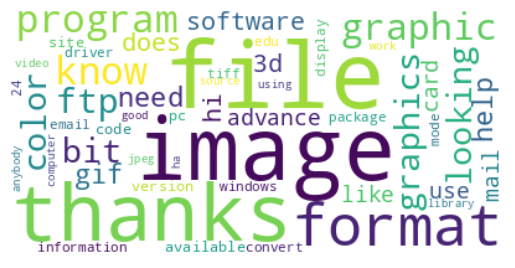

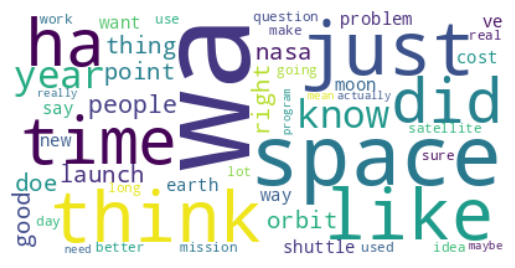

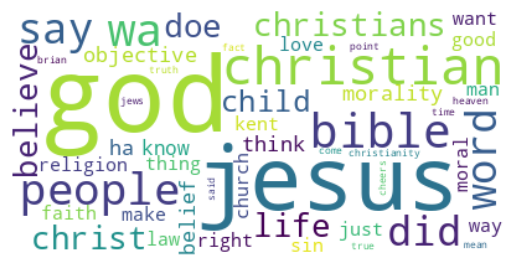

In [ ]:
for i in range(true_k):
    freq = frequencies_dict(i)
    makeImage(freq)
    print()